# Introduction to Euclid Q1 MER catalog

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 MER catalogs.
- What columns are available in the MER catalog.
- How to query with ADQL in the MER catalog.
- How to make a simple color-magnitude diagram with the data.

## Introduction

Euclid is a European Space Agency (ESA) space mission with NASA participation, to study the geometry and nature of the dark Universe.
The Quick Data Release 1 (Q1) are the first data release from the Euclid mission after the Early Release Observations (ERO).
On March 19, 2025 the data will be available on the [ESA archive](https://easidr.esac.esa.int/sas/) and on the [IRSA archive](https://irsa.ipac.caltech.edu).

These Q1 notebooks focus on how to access, download, and process Euclid Q1 data from the IRSA archive.
If you have any issues accessing data from the archives, please contact the helpdesk directly: [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) and [ESA Euclid Helpdesk](https://support.cosmos.esa.int/euclid).

Each entry in the MER catalog is a single source containing all its photometry from the MER Mosaics (VIS, Y, J, H and any accompanying external ground observations) along with other basic measurements, like size and shape.

This notebook provides an introduction to the MER catalog released as part of Euclid Q1.
Other Euclid notebooks show how to use other data products released as part of Euclid Q1.

## Imports

In [1]:
# Uncomment the next line to install dependencies if needed
# !pip install numpy matplotlib pyvo

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyvo as vo

## 1. Download MER catalog from IRSA directly to this notebook

In [3]:
service = vo.dal.TAPService("https://irsa.ipac.caltech.edu/TAP")

In [4]:
tables = service.tables
for tablename in tables.keys():
    if "tap_schema" not in tablename and "euclid_q1" in tablename:
            tables[tablename].describe()

euclid.artifact_euclid_q1
    Euclid Q1 CAOM Artifact Table

euclid.observation_euclid_q1
    Euclid Q1 CAOM Observation Table
euclid.plane_euclid_q1
    Euclid Q1 CAOM Plane Table
euclid_q1_mer_catalogue
    Euclid Q1 MER Catalog

euclid_q1_mer_morphology
    Euclid Q1 MER Morphology
euclid_q1_phz_photo_z
    Euclid Q1 PHZ Photo-z Catalog

euclid_q1_spe_lines_atomic_indices
    Euclid Q1 SPE Lines Catalog - Atomic Indices
euclid_q1_spe_lines_continuum_features
    Euclid Q1 SPE Lines Catalog - Continuum Features

euclid_q1_spe_lines_line_features
    Euclid Q1 SPE Lines Catalog - Spectral Lines
euclid_q1_spe_lines_molecular_indices
    Euclid Q1 SPE Lines Catalog - Molecular Indices

euclid_q1_spectro_zcatalog_spe_classification
    Euclid Q1 SPE Redshift Catalog - Classification
euclid_q1_spectro_zcatalog_spe_galaxy_candidates
    Euclid Q1 SPE Redshift Catalog - Galaxy Candidates

euclid_q1_spectro_zcatalog_spe_qso_candidates
    Euclid Q1 SPE Redshift Catalog - QSO Candidates
eucli

euclid.plane_euclid_q1
    Euclid Q1 CAOM Plane Table



euclid_q1_mer_catalogue
    Euclid Q1 MER Catalog

euclid_q1_mer_morphology
    Euclid Q1 MER Morphology



euclid_q1_phz_photo_z
    Euclid Q1 PHZ Photo-z Catalog

euclid_q1_spe_lines_atomic_indices
    Euclid Q1 SPE Lines Catalog - Atomic Indices



euclid_q1_spe_lines_continuum_features
    Euclid Q1 SPE Lines Catalog - Continuum Features

euclid_q1_spe_lines_line_features
    Euclid Q1 SPE Lines Catalog - Spectral Lines



euclid_q1_spe_lines_molecular_indices
    Euclid Q1 SPE Lines Catalog - Molecular Indices

euclid_q1_spectro_zcatalog_spe_classification
    Euclid Q1 SPE Redshift Catalog - Classification



euclid_q1_spectro_zcatalog_spe_galaxy_candidates
    Euclid Q1 SPE Redshift Catalog - Galaxy Candidates

euclid_q1_spectro_zcatalog_spe_qso_candidates
    Euclid Q1 SPE Redshift Catalog - QSO Candidates



euclid_q1_spectro_zcatalog_spe_quality
    Euclid Q1 SPE Redshift Catalog - Quality

euclid_q1_spectro_zcatalog_spe_star_candidates
    Euclid Q1 SPE Redshift Catalog - Star Candidates



### Choose the Euclid MER table

In [5]:
table_mer = 'euclid_q1_mer_catalogue'

### Learn some information about the table:
- How many columns are there?
- List the column names

In [6]:
columns = tables[table_mer].columns
print(len(columns))

476


In [7]:
for col in columns:
    print(f'{f"{col.name}":30s}  {col.unit}  {col.description}')

object_id                       NA  Euclid unique source identifier
ra                              deg  Source barycenter RA coordinate (SExtractor ALPHA_J2000) decimal degrees
dec                             deg  Source barycenter DEC coordinate (SExtractor DELTA_J2000) decimal degrees
right_ascension_psf_fitting     deg  Source RA coordinate derived by the PSF-fitting photometry method
declination_psf_fitting         deg  Source DEC coordinate derived by the PSF-fitting photometry method
segmentation_map_id             NA  Source ID in the associated segmentation map
vis_det                         NA  Flag to indicate if the source is detected in the VIS mosaic (1) or is only detected in the NIR mosaic (0)
flux_vis_1fwhm_aper             uJy  VIS band source aperture photometry flux (1 FWHM diameter) on PSF-matched images
flux_vis_2fwhm_aper             uJy  VIS band source aperture photometry flux (2 FWHM diameter) on PSF-matched images
flux_vis_3fwhm_aper             uJy  VIS ban

### Define the following ADQL query to find the first 10k stars in the MER catalog

Since we are just using the MER catalog alone, it does not have a column for classification. We can use the point_like_flag = 1 or point_like_prob>0.99 for stars.

Set all the fluxes to be greater than 0 so the object is detected in all four Euclid MER mosaic images

In [8]:
adql_stars = ("SELECT TOP 10000 mer.ra, mer.dec, mer.flux_vis_psf, mer.fluxerr_vis_psf, mer.flux_y_templfit,mer.fluxerr_y_templfit, "
    "mer.flux_j_templfit, mer.fluxerr_j_templfit, mer.flux_h_templfit, mer.fluxerr_h_templfit, mer.point_like_prob, mer.extended_prob "
    f"FROM {table_mer} AS mer "
    "WHERE  mer.flux_vis_psf > 0 "
    "AND mer.flux_y_templfit > 0 "
    "AND mer.flux_j_templfit > 0 "
    "AND mer.flux_h_templfit > 0 "
    "AND mer.point_like_flag = 1 ")

# Run the query

result_stars = service.search(adql_stars)

In [9]:
df_s_irsa = result_stars.to_table().to_pandas()   # Convert to Pandas DataFrame

# Display first few rows
df_s_irsa.head()

,ra,dec,flux_vis_psf,fluxerr_vis_psf,flux_y_templfit,fluxerr_y_templfit,flux_j_templfit,fluxerr_j_templfit,flux_h_templfit,fluxerr_h_templfit,point_like_prob,extended_prob
0,59.078681,-51.473721,22.240271,0.110778,88.048264,0.968541,100.079498,0.976982,102.687408,0.882893,0.962297,NaN
1,58.957938,-51.473768,22.773048,0.108161,35.686611,0.569915,45.867817,0.624888,45.841610,0.634713,0.978700,NaN
2,58.973497,-51.477646,8.983518,0.072970,24.201298,0.487317,28.257515,0.484978,30.431122,0.524141,0.981156,NaN
3,59.077169,-51.466139,131.335403,0.271436,165.179672,1.304662,190.656906,1.278318,163.389511,1.261251,0.999248,NaN
4,58.518014,-51.468094,38.494297,0.137431,0.138735,0.102561,0.041126,0.100962,0.118098,0.286662,0.988542,NaN


## 2. Make a color-magnitude diagram using the catalogs pulled from IRSA

- Convert from flux in uJy to magnitudes using the zero point correction
- Convert the error bars to magnitudes as well
- Plot the color-magnitude diagram

Text(0.5, 1.0, '10k Stars in MER catalog -- IRSA')

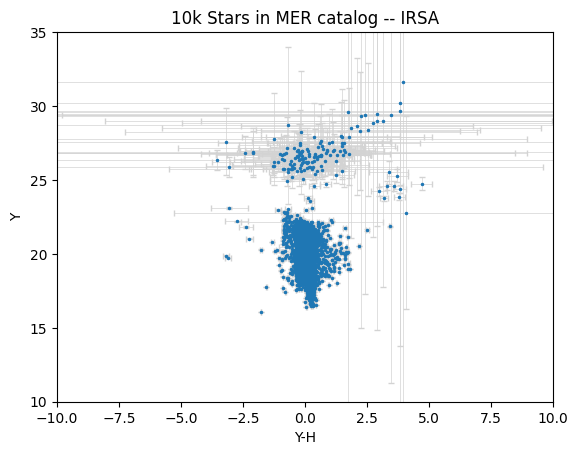

In [10]:
mag_y_s_irsa=-2.5*np.log10(df_s_irsa["flux_y_templfit"]) + 23.9 # Y
mag_h_s_irsa=-2.5*np.log10(df_s_irsa["flux_h_templfit"]) + 23.9 # H

x_s_irsa = mag_y_s_irsa - mag_h_s_irsa # Y - H
y_s_irsa = mag_y_s_irsa

xerr_s_irsa= 2.5 / np.log(10) * np.sqrt((df_s_irsa["fluxerr_y_templfit"] / df_s_irsa["flux_y_templfit"])**2
                                 + (df_s_irsa["fluxerr_h_templfit"] / df_s_irsa["flux_h_templfit"])**2)
yerr_s_irsa= 2.5 / np.log(10) * (df_s_irsa["fluxerr_y_templfit"] / df_s_irsa["flux_y_templfit"])

plt.errorbar(x_s_irsa, y_s_irsa, xerr=xerr_s_irsa, yerr=yerr_s_irsa, fmt='o', markersize=1.5, ecolor='lightgrey', elinewidth=0.5, capsize=2)

plt.xlabel('Y-H')
plt.ylabel('Y')
plt.xlim(-10,10)
plt.ylim(10,35)
plt.title('10k Stars in MER catalog -- IRSA')

## About this Notebook

**Author**: Tiffany Meshkat (IPAC Scientist)

**Updated**: 2025-03-19

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.